#### **Setup Training Configuration**
Configure all the necessary parameters for training.


In [1]:
NUM_TRAIN_STEPS = 500
MODEL_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
CONFIG_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync'

import os

CHECKPOINT_PATH = '/content/checkpoint'
OUTPUT_PATH     = '/content/output'
EXPORTED_PATH   = '/content/exported'
DATA_PATH       = '/content/data'

LABEL_MAP_PATH    = os.path.join(DATA_PATH, 'labelmap.pbtxt')
TRAIN_RECORD_PATH = os.path.join(DATA_PATH, 'train.record')
VAL_RECORD_PATH   = os.path.join(DATA_PATH, 'val.record')

#### **Mount Google Drive**
To access the dataset stored on your Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Install the TensorFlow Object Detection API**
Install and setup TensorFlow Object Detection API, Protobuf and other necessary dependencies.


In [3]:
%tensorflow_version 1.x
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/cloud-annotations/models

!pip install cloud-annotations==0.0.4
!pip install tf_slim
!pip install lvis
!pip install --no-deps tensorflowjs==1.4.0

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

pwd = os.getcwd()
os.environ['PYTHONPATH'] += f':{pwd}:{pwd}/slim'

TensorFlow 1.x selected.
Cloning into 'models'...
remote: Enumerating objects: 2282, done.
remote: Counting objects: 100% (2282/2282), done.
remote: Compressing objects: 100% (1930/1930), done.
remote: Total 2282 (delta 523), reused 1238 (delta 326), pack-reused 0
Receiving objects: 100% (2282/2282), 30.58 MiB | 36.58 MiB/s, done.
Resolving deltas: 100% (523/523), done.
     |████████████████████████████████| 358kB 16.9MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
/content/models/research


#### **Test the setup**
Run the model builder test to verify if everything is setup successfully.

In [4]:
!python object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_wi

#### **Copy the dataset folder from Google Drive.**
Get the dataset of images and annotations saved on your Drive.

In [5]:
%cp -r /content/drive/MyDrive/TFJS-Custom-Detection/ /content/
%cd /content/
%mkdir data

/content


#### **Convert XML annotations into CSV**
All the PascalVOC labels are converted into a CSV file for training and testing data.

In [6]:
%cd /content/
!wget https://raw.githubusercontent.com/NSTiwari/TensorFlow.js-Custom-Object-Detection/master/xml_to_csv.py
!python xml_to_csv.py

/content
--2021-02-08 09:52:21--  https://raw.githubusercontent.com/NSTiwari/TensorFlow.js-Custom-Object-Detection/master/xml_to_csv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223 (1.2K) [text/plain]
Saving to: ‘xml_to_csv.py’

xml_to_csv.py       100%[===================>]   1.19K  --.-KB/s    in 0s      

2021-02-08 09:52:21 (69.4 MB/s) - ‘xml_to_csv.py’ saved [1223/1223]

Successfully converted xml to csv.
Successfully converted xml to csv.


#### **Create labelmap.pbtxt file inside the data folder** 
Consider the following example:
```
item {
  name: "cat"
  id: 1
}
 
item {
  name: "dog"
  id: 2
}
 
item {
  name: "fish"
  id: 3
}


#### **Create TFRecord**

Download the generate_tf_record.py file

In [7]:
!wget https://raw.githubusercontent.com/NSTiwari/TensorFlow.js-Custom-Object-Detection/master/generate_tf_records.py

--2021-02-08 09:53:17--  https://raw.githubusercontent.com/NSTiwari/TensorFlow.js-Custom-Object-Detection/master/generate_tf_records.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5136 (5.0K) [text/plain]
Saving to: ‘generate_tf_records.py’

generate_tf_records 100%[===================>]   5.02K  --.-KB/s    in 0s      

2021-02-08 09:53:18 (72.7 MB/s) - ‘generate_tf_records.py’ saved [5136/5136]



In [8]:
!python /content/generate_tf_records.py -l /content/data/labelmap.pbtxt -o data/train.record -i TFJS-Custom-Detection/images -csv TFJS-Custom-Detection/train_labels.csv
!python /content/generate_tf_records.py -l /content/data/labelmap.pbtxt -o data/val.record -i TFJS-Custom-Detection/images -csv TFJS-Custom-Detection/val_labels.csv

INFO:Successfully created the TFRecords: data/train.record
INFO:Successfully created the TFRecords: data/val.record


#### **Navigate to models/research directory**

In [9]:
%cd /content/models/research

/content/models/research


#### **Download a base model**
Training a model from scratch can take a lot of computation time. Instead, we choose to apply Transfer Learning on a pre-trained model. Transfer Learning helps to decrease computations and time, of course, to a great extent. The base model we'll be using is the MobileNet model which is very fast.

In [10]:
import os
import tarfile

import six.moves.urllib as urllib

download_base = 'http://download.tensorflow.org/models/object_detection/'
model = MODEL_TYPE + '.tar.gz'
tmp = '/content/checkpoint.tar.gz'

if not (os.path.exists(CHECKPOINT_PATH)):
  # Download the checkpoint
  opener = urllib.request.URLopener()
  opener.retrieve(download_base + model, tmp)

  # Extract all the `model.ckpt` files.
  with tarfile.open(tmp) as tar:
    for member in tar.getmembers():
      member.name = os.path.basename(member.name)
      if 'model.ckpt' in member.name:
        tar.extract(member, path=CHECKPOINT_PATH)

  os.remove(tmp)

#### **Model Configuration**
Before the training begins, we need to configure the training pipeline by specifying the paths for labelmap, TFRecord and checkpoint. The default batch size is 128 which also needs to be changed as it is too large to be handled by Colab.


In [ ]:
import re

from google.protobuf import text_format

from object_detection.utils import config_util
from object_detection.utils import label_map_util

pipeline_skeleton = '/content/models/research/object_detection/samples/configs/' + CONFIG_TYPE + '.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_skeleton)

label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)
num_classes = len(label_map.keys())
meta_arch = configs["model"].WhichOneof("model")

override_dict = {
  'model.{}.num_classes'.format(meta_arch): num_classes,
  'train_config.batch_size': 24,
  'train_input_path': TRAIN_RECORD_PATH,
  'eval_input_path': VAL_RECORD_PATH,
  'train_config.fine_tune_checkpoint': os.path.join(CHECKPOINT_PATH, 'model.ckpt'),
  'label_map_path': LABEL_MAP_PATH
}

configs = config_util.merge_external_params_with_configs(configs, kwargs_dict=override_dict)
pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_config, DATA_PATH)

#### **Start training**
Run the cell below to start training the model. Training is invoked by calling the `model_main` script and passing the following arguments to it.

- The location of the `pipepline.config` we created
- Where we want to save the model
- How many steps we want to train the model (the longer you train, the more potential there is to learn)
- The number of evaluation steps (or how often to test the model) gives us an idea of how well the model is doing

In [ ]:
!rm -rf $OUTPUT_PATH
!python -m object_detection.model_main \
    --pipeline_config_path=$DATA_PATH/pipeline.config \
    --model_dir=$OUTPUT_PATH \
    --num_train_steps=$NUM_TRAIN_STEPS \
    --num_eval_steps=100

#### **Export inference graph**
Checkpoints are generated after every 500 training steps. Each checkpoint is a snapshot of your model at that point in training. If for some reason the training crashes due to network or power failure, then you can continue the training from the last checkpoint instead of starting it all over.


In [ ]:
import os
import re

regex = re.compile(r"model\.ckpt-([0-9]+)\.index")
numbers = [int(regex.search(f).group(1)) for f in os.listdir(OUTPUT_PATH) if regex.search(f)]
TRAINED_CHECKPOINT_PREFIX = os.path.join(OUTPUT_PATH, 'model.ckpt-{}'.format(max(numbers)))

print(f'Using {TRAINED_CHECKPOINT_PREFIX}')

!rm -rf $EXPORTED_PATH
!python -m object_detection.export_inference_graph \
  --pipeline_config_path=$DATA_PATH/pipeline.config \
  --trained_checkpoint_prefix=$TRAINED_CHECKPOINT_PREFIX \
  --output_directory=$EXPORTED_PATH

#### **Testing the model**
Now, let's test the model on some images. Remember that the model was trained only for 500 steps. So, the accuracy might not be that great. Run the cell below to test the model for yourself and find out how well the model was trained.

> **Note:** Try training the model for 5,000 steps and see how the accuracy changes. Play around with other model formats, like the non-quantized version of SSD MobileNet v1 or Faster R-CNN.

<IPython.core.display.Javascript object>

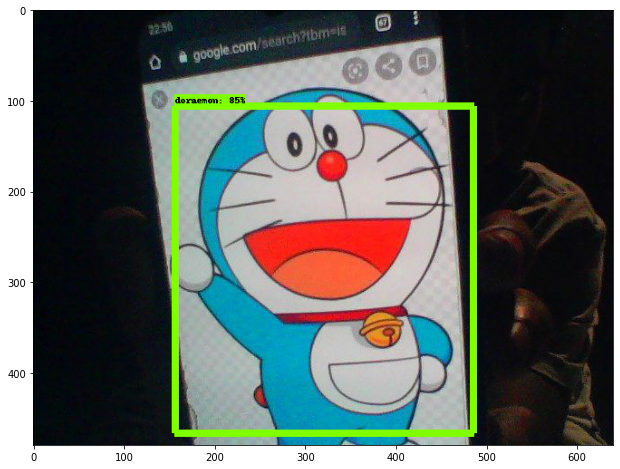

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import tensorflow as tf

# Use javascipt to take a photo.
def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  take_photo('/content/photo.jpg')
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Use the captured photo to make predictions
%matplotlib inline

import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as PImage
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

# Load the labels
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

# Load the model
path_to_frozen_graph = os.path.join(EXPORTED_PATH, 'frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    image = PImage.open('/content/photo.jpg')
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

#### **Convert the model into TFJS**
The model we exported works well with Python. However, to deploy it on the web browser, we need to convert it into TensorFlow.js so that it becomes compatible to be run directly on the browser

Also, the model only detects objects as the IDs specified in the `label_map.pbtxt`. Therefore, we also need to create a JSON list of all of our labels that can be mapped to the ID.

In [ ]:
!tensorflowjs_converter \
  --input_format=tf_frozen_model \
  --output_format=tfjs_graph_model \
  --output_node_names='Postprocessor/ExpandDims_1,Postprocessor/Slice' \
  --quantization_bytes=1 \
  --skip_op_check \
  $EXPORTED_PATH/frozen_inference_graph.pb \
  /content/model_web

import json

from object_detection.utils.label_map_util import get_label_map_dict

label_map = get_label_map_dict(LABEL_MAP_PATH)
label_array = [k for k in sorted(label_map, key=label_map.get)]

with open(os.path.join('/content/model_web', 'labels.json'), 'w') as f:
  json.dump(label_array, f)

!cd /content/model_web && zip -r /content/model_web.zip *

#### **Download the model**
The TFJS model is now ready to be downloaded.

> **Note:** Sometimes this command doesn't run or it will throw an error. Just try running it again.

You can also download the model by right clicking on the `model_web.zip` file in the left sidebar file inspector.

In [ ]:
from google.colab import files
files.download('/content/model_web.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>